# Building the Image Classifier

We want to use a auxiliary classifier GAN (AC-GAN) with a pretrained classifier. In this notebook we build, train and save this classifier. The architecture we used here is very similar to the VGG16 architecture.


### Load in Data and Split into Test/Train Sets

In [1]:
import pickle as pkl


def get_dataset():
    """
    Load in the dataset and split into test and training sets.
    
    Function loads in the dataset built in the 'creating_full_dataset'. This dataset
    contains all the images, along with the EEG embeddings and one-hot encoded labels.
    This dataset has already been shuffled.
    
    return: a list containing the test and train features (images) and labels.
    """
    
    with open("../build_dataset/dataset_shuf.pkl", "rb") as f:
        dataset_shuf = pkl.load(f)

    test_ratio = 0.1
    tot_num_images=dataset_shuf[0].shape[0]
    test_size = int(test_ratio*tot_num_images)

    test_lab = dataset_shuf[0][:test_size]
    test_img = dataset_shuf[2][:test_size]

    train_lab = dataset_shuf[0][test_size:]
    train_img = dataset_shuf[2][test_size:]
    
    return [(train_img,train_lab),(test_img,test_lab)]


dataset = get_dataset()

### Function to Build Classifier

In [8]:
from keras.models import Model
from keras.layers import Dense, Flatten, MaxPooling2D, Reshape, LeakyReLU, Dropout, Input
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam


def build_classifier(learning_rate):
    """
    Builds the Keras CNN to classify the images in the dataset. 
    
    This is based on the VGG16 architecture (using 8 CNN layers). It uses the Keras 
    functional API.
    
    return: Keras model: a CNN model with CCE loss and Adam optimizer. Takes 64x64x3 
    input and outputs a 20-length vector representing the class prediction.
    """
    image_input = Input(shape=(64,64,3))
    #1
    x = Conv2D(32, (3, 3), strides=1, name='c1',padding='same')(image_input)
    x = LeakyReLU(0.2)(x)
    #2
    x = Conv2D(32, (3, 3), strides=1, name='c2')(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    x = Dropout(0.5)(x)
    #3
    x = Conv2D(64, (3, 3), strides=1, name='c3', padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #4
    x = Conv2D(64, (3, 3), strides=1)(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    x = Dropout(0.5)(x)
    #5
    x = Conv2D(128, (3, 3), strides=1,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #6
    x = Conv2D(128, (3, 3), strides=1)(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    x = Dropout(0.5)(x)
    #7
    x = Conv2D(256, (3, 3), strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #8
    x = Conv2D(256, (3, 3), strides=1)(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    x = Dropout(0.5)(x)
  
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
  
    output = Dense(20, activation='softmax')(x)
  
    model = Model(image_input,output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

# Training the Model

### Some Useful Functions

These functions will help with training and monitoring performance.

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def plot_losses(epoch, train_loss_array, test_loss_array):
    """
    Function to plot the training and test loss for each epoch.
    
    input: epoch: number of epochs completed so far in the training process.
    input: train_loss_array: an array of the training losses for each epoch.
    input: test_loss_array: an array of the test losses for each epoch.
    """
    x_axis = np.linspace(1, epoch, epoch)
    print("Performance:")
    plt.plot(x_axis, train_loss_array, label='train loss', linewidth=1)
    plt.plot(x_axis, test_loss_array, label='test loss', linewidth=1)
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.show()


def shuffle_training_set(x_train, y_train):
    """
    Shuffle the training set randomly.
    
    Function takes in the features and targets, creates random indices and uses
    these to shuffle the training set up. 
    
    return: a shuffled features and target array.
    """
    shuffle_indices = np.arange(x_train.shape[0])
    np.random.shuffle(shuffle_indices)
    return x_train[shuffle_indices], y_train[shuffle_indices]
    



def test_in_batches(classifier, x_test, y_test):
    """
    Function to allow testing to be done in batches. This is to avoid OOM errors with
    large datasets (and therefore large test sets).
    
    return: test_loss: average loss of the model on all batches.
    return: test_accuracy: average accuracy of the model on all batches.
    """
    test_size = x_test.shape[0]
    
    batch_size = 250
    num_batches = int(test_size/batch_size)
    test_loss = 0
    test_accuracy = 0
    
    for batch in range(num_batches):
        x_test_batch = x_test[batch*batch_size : (batch+1)*batch_size]
        y_test_batch = y_test[batch*batch_size : (batch+1)*batch_size]
        # Test
        test_batch_loss, test_batch_accuracy = classifier.test_on_batch(x_test_batch, y_test_batch)
        
        test_loss += test_batch_loss/num_batches
        test_accuracy += test_batch_accuracy/num_batches
    
        
    return test_loss, test_accuracy

### Training Function

In [6]:
def train(num_epochs,batch_size, classifier,dataset,plot_losses_at_epoch):
    """
    Trains the classifier on all images and prints the performance
    
    Function trains the models using Keras' train_on_batch and tests using my 
    test_in_batches function (to avoid OOM errors). It stores losses in numpy
    arrays so it can plot them later on. After each epoch it saves the Keras
    model as 'image_classifier.h5'. 
    
    input: num_epochs: number of epochs to train the model on.
    input: batch_size: batch size used in the mini-batch gradient descent.
    input: classifier: Keras model we wish to train.
    input: dataset: dataset with test and training sets we wish to train our 
                    model on.
    input: plot_losses_at_epoch: how often to print the loss.
    """
    (x_train, y_train), (x_test, y_test) = dataset
    
    batches_per_epo = int(x_train.shape[0]/batch_size)
  
    train_loss_array = np.array([])
    test_loss_array = np.array([])

    # train over epochs
    for i in range(num_epochs):
        epoch = i + 1
        train_loss = 0
        train_accuracy = 0
        
        # shuffle data
        x_train_shuffled, y_train_shuffled = shuffle_training_set(x_train, y_train)
        
        # train over batches
        for batch in range(batches_per_epo):
            x_train_batch = x_train_shuffled[batch*batch_size : (batch+1)*batch_size]
            y_train_batch = y_train_shuffled[batch*batch_size : (batch+1)*batch_size]
            # train classifier
            train_batch_loss, train_batch_accuracy = classifier.train_on_batch(x_train_batch, y_train_batch)
            # update performance values
            train_loss += train_batch_loss/batches_per_epo
            train_accuracy += train_batch_accuracy/batches_per_epo
    
    
        # test on the full test set
        test_loss, test_accuracy = test_in_batches(classifier, x_test, y_test)
        
        # save performance values into an array
        train_loss_array = np.append(train_loss_array, train_loss)
        test_loss_array = np.append(test_loss_array, test_loss)

        # print performance
        print("Epoch {0}: train_loss={1:.4f}, train_accuracy={2:.4f}, test_loss={3:.4f}, test_accuracy={4:.4f}.".format(
            epoch,
            train_loss,
            train_accuracy,
            test_loss,
            test_accuracy))
        
        # plot losses every plot_losses_at_epoch-th epoch
        if epoch % plot_losses_at_epoch == 0 and epoch is not 1:
            plot_losses(epoch, train_loss_array, test_loss_array)
            
        # save model   
        classifier.save('image_classifier.h5')

### Training

Note that the reason for test loss being smaller than the training loss (in the earlier parts of training) is almost certaintly due to the large amount of dropout layers (which aren't applied when testing). 

Epoch 1: train_loss=2.9715, train_accuracy=0.0666, test_loss=2.8524, test_accuracy=0.1029.
Epoch 2: train_loss=2.7842, train_accuracy=0.1187, test_loss=2.6516, test_accuracy=0.1756.
Epoch 3: train_loss=2.5544, train_accuracy=0.1970, test_loss=2.3345, test_accuracy=0.2720.
Epoch 4: train_loss=2.3433, train_accuracy=0.2793, test_loss=2.0757, test_accuracy=0.3607.
Epoch 5: train_loss=2.1437, train_accuracy=0.3483, test_loss=1.9578, test_accuracy=0.4262.
Epoch 6: train_loss=1.9642, train_accuracy=0.4139, test_loss=1.7799, test_accuracy=0.4658.
Epoch 7: train_loss=1.8324, train_accuracy=0.4584, test_loss=1.7150, test_accuracy=0.4825.
Epoch 8: train_loss=1.7224, train_accuracy=0.4938, test_loss=1.6117, test_accuracy=0.5131.
Epoch 9: train_loss=1.6221, train_accuracy=0.5249, test_loss=1.3978, test_accuracy=0.5818.
Epoch 10: train_loss=1.5983, train_accuracy=0.5356, test_loss=1.3882, test_accuracy=0.5862.
Performance:


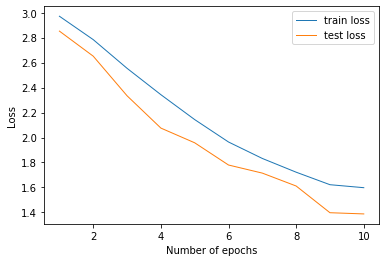

Epoch 11: train_loss=1.5560, train_accuracy=0.5530, test_loss=1.4118, test_accuracy=0.5796.
Epoch 12: train_loss=1.4908, train_accuracy=0.5686, test_loss=1.3082, test_accuracy=0.6080.
Epoch 13: train_loss=1.4249, train_accuracy=0.5895, test_loss=1.3893, test_accuracy=0.5876.
Epoch 14: train_loss=1.3969, train_accuracy=0.5982, test_loss=1.3601, test_accuracy=0.6007.
Epoch 15: train_loss=1.3877, train_accuracy=0.6014, test_loss=1.2841, test_accuracy=0.6189.
Epoch 16: train_loss=1.3440, train_accuracy=0.6142, test_loss=1.2786, test_accuracy=0.6265.
Epoch 17: train_loss=1.3040, train_accuracy=0.6250, test_loss=1.3672, test_accuracy=0.5982.
Epoch 18: train_loss=1.3043, train_accuracy=0.6282, test_loss=1.1854, test_accuracy=0.6476.
Epoch 19: train_loss=1.2627, train_accuracy=0.6374, test_loss=1.2205, test_accuracy=0.6367.
Epoch 20: train_loss=1.2603, train_accuracy=0.6405, test_loss=1.1233, test_accuracy=0.6691.
Performance:


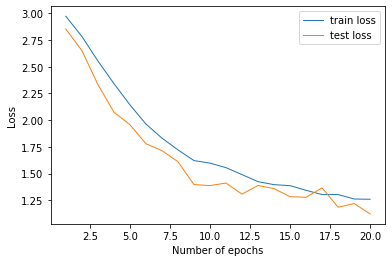

Epoch 21: train_loss=1.2440, train_accuracy=0.6464, test_loss=1.2410, test_accuracy=0.6429.
Epoch 22: train_loss=1.2195, train_accuracy=0.6507, test_loss=1.0746, test_accuracy=0.6800.
Epoch 23: train_loss=1.1945, train_accuracy=0.6564, test_loss=1.1741, test_accuracy=0.6524.
Epoch 24: train_loss=1.1861, train_accuracy=0.6648, test_loss=1.1855, test_accuracy=0.6498.
Epoch 25: train_loss=1.1887, train_accuracy=0.6598, test_loss=1.1318, test_accuracy=0.6651.
Epoch 26: train_loss=1.1739, train_accuracy=0.6685, test_loss=1.0821, test_accuracy=0.6778.
Epoch 27: train_loss=1.1640, train_accuracy=0.6716, test_loss=1.0617, test_accuracy=0.6876.
Epoch 28: train_loss=1.1466, train_accuracy=0.6735, test_loss=1.0600, test_accuracy=0.6927.
Epoch 29: train_loss=1.1374, train_accuracy=0.6768, test_loss=1.0311, test_accuracy=0.6996.
Epoch 30: train_loss=1.1248, train_accuracy=0.6826, test_loss=1.1506, test_accuracy=0.6716.
Performance:


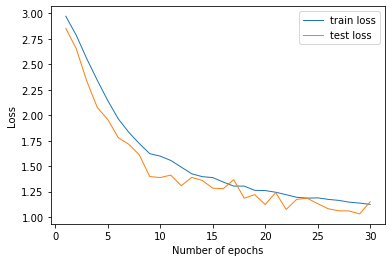

Epoch 31: train_loss=1.1018, train_accuracy=0.6870, test_loss=1.0950, test_accuracy=0.6869.
Epoch 32: train_loss=1.1024, train_accuracy=0.6866, test_loss=1.0721, test_accuracy=0.6964.
Epoch 33: train_loss=1.0834, train_accuracy=0.6914, test_loss=1.1068, test_accuracy=0.6844.
Epoch 34: train_loss=1.0805, train_accuracy=0.6949, test_loss=1.1375, test_accuracy=0.6742.
Epoch 35: train_loss=1.0815, train_accuracy=0.6910, test_loss=1.0601, test_accuracy=0.6982.
Epoch 36: train_loss=1.0670, train_accuracy=0.6978, test_loss=1.0637, test_accuracy=0.6924.
Epoch 37: train_loss=1.0374, train_accuracy=0.7047, test_loss=0.9799, test_accuracy=0.7087.
Epoch 38: train_loss=1.0515, train_accuracy=0.7011, test_loss=0.9871, test_accuracy=0.7113.
Epoch 39: train_loss=1.0312, train_accuracy=0.7087, test_loss=0.9827, test_accuracy=0.7164.
Epoch 40: train_loss=1.0326, train_accuracy=0.7070, test_loss=1.0140, test_accuracy=0.7047.
Performance:


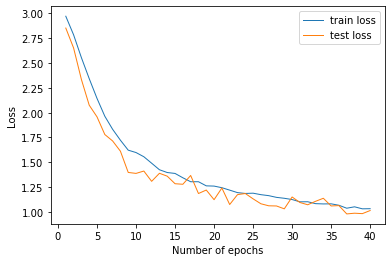

Epoch 41: train_loss=1.0302, train_accuracy=0.7096, test_loss=1.1570, test_accuracy=0.6880.
Epoch 42: train_loss=1.0327, train_accuracy=0.7075, test_loss=1.0753, test_accuracy=0.6945.
Epoch 43: train_loss=1.0088, train_accuracy=0.7136, test_loss=0.9560, test_accuracy=0.7236.
Epoch 44: train_loss=0.9885, train_accuracy=0.7192, test_loss=0.9627, test_accuracy=0.7189.
Epoch 45: train_loss=1.0113, train_accuracy=0.7166, test_loss=0.9482, test_accuracy=0.7284.
Epoch 46: train_loss=0.9890, train_accuracy=0.7198, test_loss=0.9486, test_accuracy=0.7244.
Epoch 47: train_loss=0.9918, train_accuracy=0.7180, test_loss=1.0235, test_accuracy=0.7087.
Epoch 48: train_loss=0.9892, train_accuracy=0.7203, test_loss=0.9800, test_accuracy=0.7131.
Epoch 49: train_loss=0.9862, train_accuracy=0.7209, test_loss=0.9048, test_accuracy=0.7316.
Epoch 50: train_loss=0.9855, train_accuracy=0.7255, test_loss=0.9871, test_accuracy=0.7251.
Performance:


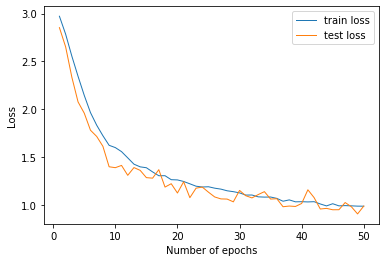

Epoch 51: train_loss=0.9769, train_accuracy=0.7228, test_loss=1.0703, test_accuracy=0.7058.
Epoch 52: train_loss=0.9651, train_accuracy=0.7271, test_loss=0.9536, test_accuracy=0.7291.
Epoch 53: train_loss=0.9737, train_accuracy=0.7246, test_loss=0.9792, test_accuracy=0.7218.
Epoch 54: train_loss=0.9606, train_accuracy=0.7276, test_loss=0.9473, test_accuracy=0.7247.
Epoch 55: train_loss=0.9637, train_accuracy=0.7248, test_loss=0.9295, test_accuracy=0.7335.
Epoch 56: train_loss=0.9547, train_accuracy=0.7277, test_loss=0.9809, test_accuracy=0.7258.
Epoch 57: train_loss=0.9533, train_accuracy=0.7316, test_loss=1.0513, test_accuracy=0.7211.
Epoch 58: train_loss=0.9345, train_accuracy=0.7353, test_loss=0.9393, test_accuracy=0.7276.
Epoch 59: train_loss=0.9538, train_accuracy=0.7324, test_loss=1.0520, test_accuracy=0.7095.
Epoch 60: train_loss=0.9430, train_accuracy=0.7367, test_loss=0.9703, test_accuracy=0.7302.
Performance:


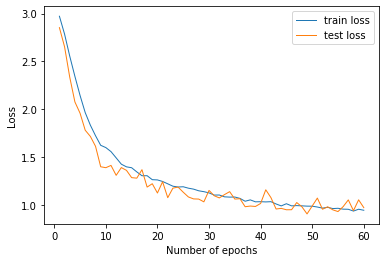

Epoch 61: train_loss=0.9292, train_accuracy=0.7388, test_loss=0.9578, test_accuracy=0.7331.
Epoch 62: train_loss=0.9147, train_accuracy=0.7396, test_loss=1.0334, test_accuracy=0.7175.
Epoch 63: train_loss=0.9356, train_accuracy=0.7381, test_loss=1.0031, test_accuracy=0.7287.
Epoch 64: train_loss=0.9244, train_accuracy=0.7409, test_loss=0.9512, test_accuracy=0.7211.
Epoch 65: train_loss=0.9313, train_accuracy=0.7363, test_loss=0.8972, test_accuracy=0.7444.
Epoch 66: train_loss=0.9235, train_accuracy=0.7449, test_loss=0.8765, test_accuracy=0.7436.
Epoch 67: train_loss=0.9168, train_accuracy=0.7445, test_loss=0.8965, test_accuracy=0.7484.
Epoch 68: train_loss=0.9305, train_accuracy=0.7382, test_loss=0.9189, test_accuracy=0.7367.
Epoch 69: train_loss=0.9066, train_accuracy=0.7462, test_loss=0.8918, test_accuracy=0.7455.
Epoch 70: train_loss=0.8942, train_accuracy=0.7503, test_loss=1.0300, test_accuracy=0.7193.
Performance:


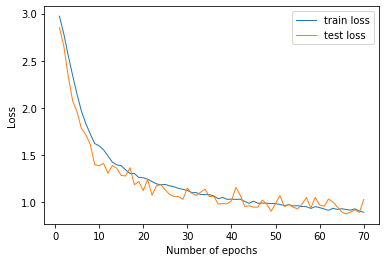

Epoch 71: train_loss=0.9016, train_accuracy=0.7482, test_loss=0.9289, test_accuracy=0.7382.
Epoch 72: train_loss=0.8947, train_accuracy=0.7461, test_loss=0.9923, test_accuracy=0.7302.
Epoch 73: train_loss=0.8923, train_accuracy=0.7517, test_loss=0.9213, test_accuracy=0.7378.
Epoch 74: train_loss=0.8793, train_accuracy=0.7513, test_loss=0.8927, test_accuracy=0.7516.
Epoch 75: train_loss=0.8856, train_accuracy=0.7550, test_loss=0.9134, test_accuracy=0.7462.
Epoch 76: train_loss=0.8689, train_accuracy=0.7565, test_loss=0.9770, test_accuracy=0.7320.
Epoch 77: train_loss=0.8987, train_accuracy=0.7467, test_loss=0.8820, test_accuracy=0.7538.
Epoch 78: train_loss=0.8727, train_accuracy=0.7587, test_loss=0.8908, test_accuracy=0.7498.
Epoch 79: train_loss=0.8694, train_accuracy=0.7534, test_loss=0.8699, test_accuracy=0.7560.
Epoch 80: train_loss=0.8877, train_accuracy=0.7513, test_loss=1.0039, test_accuracy=0.7280.
Performance:


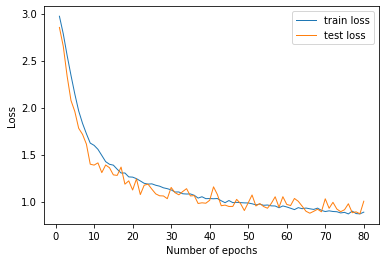

Epoch 81: train_loss=0.9052, train_accuracy=0.7506, test_loss=0.8604, test_accuracy=0.7545.
Epoch 82: train_loss=0.8726, train_accuracy=0.7559, test_loss=0.9580, test_accuracy=0.7295.
Epoch 83: train_loss=0.8676, train_accuracy=0.7571, test_loss=0.9247, test_accuracy=0.7396.
Epoch 84: train_loss=0.8581, train_accuracy=0.7559, test_loss=0.8710, test_accuracy=0.7538.
Epoch 85: train_loss=0.8612, train_accuracy=0.7581, test_loss=0.8340, test_accuracy=0.7680.
Epoch 86: train_loss=0.8776, train_accuracy=0.7560, test_loss=0.8698, test_accuracy=0.7498.
Epoch 87: train_loss=0.8516, train_accuracy=0.7614, test_loss=0.9015, test_accuracy=0.7484.
Epoch 88: train_loss=0.8704, train_accuracy=0.7573, test_loss=0.8807, test_accuracy=0.7542.
Epoch 89: train_loss=0.8744, train_accuracy=0.7572, test_loss=0.9541, test_accuracy=0.7389.
Epoch 90: train_loss=0.8614, train_accuracy=0.7583, test_loss=0.8434, test_accuracy=0.7629.
Performance:


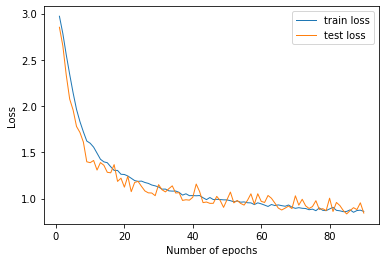

Epoch 91: train_loss=0.8538, train_accuracy=0.7617, test_loss=0.9243, test_accuracy=0.7411.
Epoch 92: train_loss=0.8756, train_accuracy=0.7566, test_loss=0.8736, test_accuracy=0.7607.
Epoch 93: train_loss=0.8532, train_accuracy=0.7628, test_loss=0.9453, test_accuracy=0.7513.
Epoch 94: train_loss=0.8426, train_accuracy=0.7659, test_loss=1.0728, test_accuracy=0.7305.
Epoch 95: train_loss=0.8507, train_accuracy=0.7636, test_loss=0.8685, test_accuracy=0.7593.
Epoch 96: train_loss=0.8515, train_accuracy=0.7634, test_loss=0.9110, test_accuracy=0.7433.
Epoch 97: train_loss=0.8450, train_accuracy=0.7630, test_loss=0.8888, test_accuracy=0.7589.
Epoch 98: train_loss=0.8409, train_accuracy=0.7663, test_loss=0.8723, test_accuracy=0.7567.
Epoch 99: train_loss=0.8414, train_accuracy=0.7693, test_loss=0.8735, test_accuracy=0.7662.
Epoch 100: train_loss=0.8403, train_accuracy=0.7653, test_loss=0.8558, test_accuracy=0.7535.
Performance:


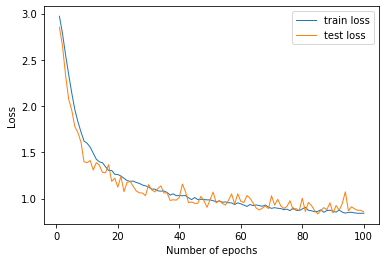

Epoch 101: train_loss=0.8422, train_accuracy=0.7634, test_loss=0.9612, test_accuracy=0.7462.
Epoch 102: train_loss=0.8439, train_accuracy=0.7662, test_loss=0.8914, test_accuracy=0.7502.
Epoch 103: train_loss=0.8579, train_accuracy=0.7600, test_loss=0.8695, test_accuracy=0.7651.
Epoch 104: train_loss=0.8500, train_accuracy=0.7653, test_loss=0.8758, test_accuracy=0.7644.
Epoch 105: train_loss=0.8255, train_accuracy=0.7729, test_loss=0.8064, test_accuracy=0.7771.
Epoch 106: train_loss=0.8430, train_accuracy=0.7660, test_loss=0.8644, test_accuracy=0.7651.
Epoch 107: train_loss=0.8483, train_accuracy=0.7642, test_loss=0.8841, test_accuracy=0.7527.
Epoch 108: train_loss=0.8367, train_accuracy=0.7690, test_loss=0.9366, test_accuracy=0.7542.
Epoch 109: train_loss=0.8157, train_accuracy=0.7745, test_loss=1.0178, test_accuracy=0.7473.
Epoch 110: train_loss=0.8225, train_accuracy=0.7721, test_loss=0.9013, test_accuracy=0.7622.
Performance:


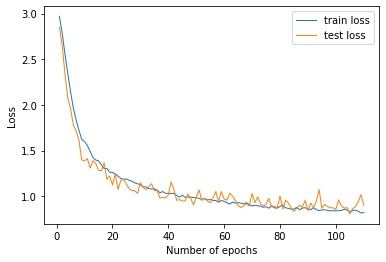

Epoch 111: train_loss=0.8389, train_accuracy=0.7683, test_loss=0.7789, test_accuracy=0.7713.
Epoch 112: train_loss=0.8106, train_accuracy=0.7736, test_loss=0.8594, test_accuracy=0.7658.
Epoch 113: train_loss=0.8425, train_accuracy=0.7681, test_loss=0.8666, test_accuracy=0.7640.
Epoch 114: train_loss=0.8422, train_accuracy=0.7696, test_loss=0.8413, test_accuracy=0.7578.
Epoch 115: train_loss=0.8146, train_accuracy=0.7755, test_loss=0.9505, test_accuracy=0.7473.
Epoch 116: train_loss=0.8697, train_accuracy=0.7661, test_loss=0.9466, test_accuracy=0.7585.
Epoch 117: train_loss=0.8417, train_accuracy=0.7698, test_loss=0.8514, test_accuracy=0.7560.
Epoch 118: train_loss=0.8336, train_accuracy=0.7718, test_loss=0.8342, test_accuracy=0.7680.
Epoch 119: train_loss=0.8138, train_accuracy=0.7768, test_loss=0.8323, test_accuracy=0.7655.
Epoch 120: train_loss=0.8285, train_accuracy=0.7715, test_loss=0.8023, test_accuracy=0.7615.
Performance:


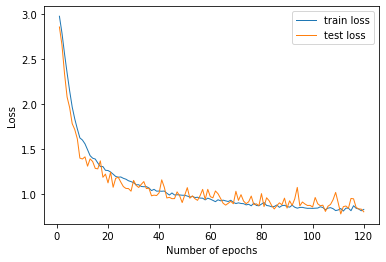

Epoch 121: train_loss=0.8049, train_accuracy=0.7767, test_loss=0.8104, test_accuracy=0.7760.
Epoch 122: train_loss=0.8011, train_accuracy=0.7817, test_loss=0.8143, test_accuracy=0.7735.
Epoch 123: train_loss=0.8094, train_accuracy=0.7773, test_loss=0.9091, test_accuracy=0.7665.
Epoch 124: train_loss=0.8045, train_accuracy=0.7775, test_loss=0.8663, test_accuracy=0.7538.
Epoch 125: train_loss=0.8346, train_accuracy=0.7722, test_loss=0.8723, test_accuracy=0.7640.
Epoch 126: train_loss=0.8641, train_accuracy=0.7647, test_loss=0.8593, test_accuracy=0.7607.
Epoch 127: train_loss=0.8177, train_accuracy=0.7737, test_loss=0.8410, test_accuracy=0.7644.
Epoch 128: train_loss=0.8322, train_accuracy=0.7716, test_loss=0.8559, test_accuracy=0.7629.
Epoch 129: train_loss=0.8159, train_accuracy=0.7798, test_loss=0.9074, test_accuracy=0.7582.
Epoch 130: train_loss=0.8169, train_accuracy=0.7764, test_loss=0.9225, test_accuracy=0.7542.
Performance:


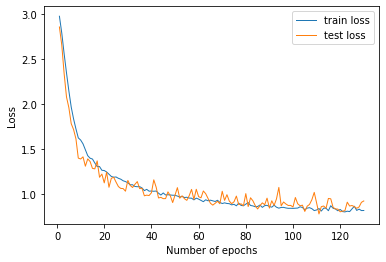

Epoch 131: train_loss=0.8083, train_accuracy=0.7793, test_loss=0.9226, test_accuracy=0.7527.
Epoch 132: train_loss=0.8260, train_accuracy=0.7724, test_loss=0.9015, test_accuracy=0.7644.
Epoch 133: train_loss=0.8292, train_accuracy=0.7735, test_loss=0.8604, test_accuracy=0.7702.
Epoch 134: train_loss=0.8204, train_accuracy=0.7774, test_loss=0.9608, test_accuracy=0.7393.
Epoch 135: train_loss=0.8241, train_accuracy=0.7768, test_loss=0.8619, test_accuracy=0.7662.
Epoch 136: train_loss=0.8025, train_accuracy=0.7791, test_loss=0.8762, test_accuracy=0.7647.
Epoch 137: train_loss=0.8053, train_accuracy=0.7808, test_loss=0.8485, test_accuracy=0.7655.
Epoch 138: train_loss=0.7929, train_accuracy=0.7810, test_loss=0.8864, test_accuracy=0.7691.
Epoch 139: train_loss=0.7876, train_accuracy=0.7845, test_loss=0.8929, test_accuracy=0.7625.
Epoch 140: train_loss=0.8062, train_accuracy=0.7793, test_loss=0.9458, test_accuracy=0.7607.
Performance:


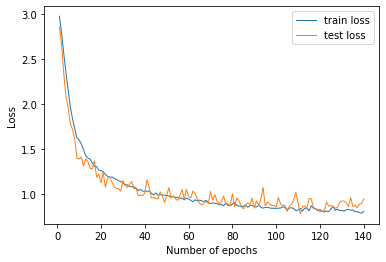

Epoch 141: train_loss=0.8111, train_accuracy=0.7760, test_loss=0.8783, test_accuracy=0.7647.
Epoch 142: train_loss=0.8885, train_accuracy=0.7634, test_loss=0.8786, test_accuracy=0.7702.
Epoch 143: train_loss=0.8587, train_accuracy=0.7654, test_loss=0.8414, test_accuracy=0.7727.
Epoch 144: train_loss=0.8336, train_accuracy=0.7729, test_loss=0.8925, test_accuracy=0.7680.
Epoch 145: train_loss=0.8148, train_accuracy=0.7789, test_loss=0.8352, test_accuracy=0.7735.
Epoch 146: train_loss=0.8038, train_accuracy=0.7806, test_loss=0.8539, test_accuracy=0.7687.
Epoch 147: train_loss=0.8400, train_accuracy=0.7722, test_loss=0.8466, test_accuracy=0.7745.
Epoch 148: train_loss=0.8228, train_accuracy=0.7793, test_loss=0.8892, test_accuracy=0.7575.
Epoch 149: train_loss=0.8402, train_accuracy=0.7707, test_loss=0.9401, test_accuracy=0.7556.
Epoch 150: train_loss=0.8159, train_accuracy=0.7781, test_loss=0.8985, test_accuracy=0.7622.
Performance:


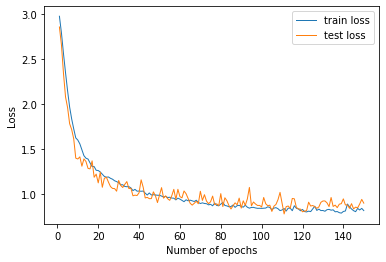

Epoch 151: train_loss=0.7955, train_accuracy=0.7841, test_loss=0.9112, test_accuracy=0.7589.
Epoch 152: train_loss=0.8150, train_accuracy=0.7786, test_loss=1.0420, test_accuracy=0.7393.
Epoch 153: train_loss=0.8130, train_accuracy=0.7785, test_loss=0.8611, test_accuracy=0.7629.
Epoch 154: train_loss=0.8183, train_accuracy=0.7770, test_loss=0.8491, test_accuracy=0.7742.
Epoch 155: train_loss=0.8119, train_accuracy=0.7772, test_loss=0.9059, test_accuracy=0.7680.
Epoch 156: train_loss=0.8134, train_accuracy=0.7804, test_loss=0.8618, test_accuracy=0.7716.
Epoch 157: train_loss=0.7918, train_accuracy=0.7841, test_loss=0.8086, test_accuracy=0.7822.
Epoch 158: train_loss=0.8217, train_accuracy=0.7783, test_loss=0.8574, test_accuracy=0.7753.
Epoch 159: train_loss=0.8250, train_accuracy=0.7793, test_loss=0.8814, test_accuracy=0.7695.
Epoch 160: train_loss=0.7999, train_accuracy=0.7861, test_loss=0.8536, test_accuracy=0.7705.
Performance:


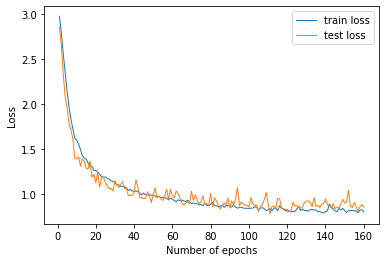

Epoch 161: train_loss=0.8061, train_accuracy=0.7822, test_loss=0.8976, test_accuracy=0.7622.
Epoch 162: train_loss=0.8209, train_accuracy=0.7756, test_loss=0.8477, test_accuracy=0.7669.
Epoch 163: train_loss=0.8286, train_accuracy=0.7771, test_loss=0.8644, test_accuracy=0.7658.
Epoch 164: train_loss=0.8020, train_accuracy=0.7802, test_loss=0.8957, test_accuracy=0.7669.
Epoch 165: train_loss=0.7908, train_accuracy=0.7819, test_loss=0.9713, test_accuracy=0.7585.
Epoch 166: train_loss=0.8244, train_accuracy=0.7788, test_loss=0.9194, test_accuracy=0.7571.
Epoch 167: train_loss=0.8312, train_accuracy=0.7744, test_loss=0.8935, test_accuracy=0.7640.
Epoch 168: train_loss=0.8353, train_accuracy=0.7755, test_loss=0.8854, test_accuracy=0.7625.
Epoch 169: train_loss=0.8161, train_accuracy=0.7810, test_loss=0.9177, test_accuracy=0.7611.
Epoch 170: train_loss=0.8278, train_accuracy=0.7782, test_loss=0.9072, test_accuracy=0.7545.
Performance:


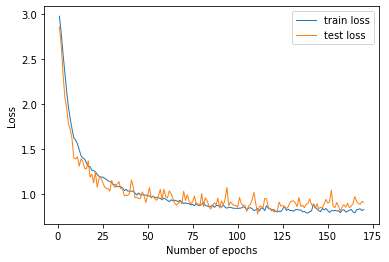

Epoch 171: train_loss=0.8361, train_accuracy=0.7763, test_loss=0.9609, test_accuracy=0.7538.
Epoch 172: train_loss=0.8324, train_accuracy=0.7767, test_loss=0.8852, test_accuracy=0.7567.
Epoch 173: train_loss=0.8110, train_accuracy=0.7795, test_loss=0.8849, test_accuracy=0.7651.
Epoch 174: train_loss=0.8206, train_accuracy=0.7786, test_loss=0.8922, test_accuracy=0.7611.
Epoch 175: train_loss=0.8267, train_accuracy=0.7780, test_loss=0.8236, test_accuracy=0.7673.
Epoch 176: train_loss=0.8051, train_accuracy=0.7832, test_loss=0.9187, test_accuracy=0.7684.
Epoch 177: train_loss=0.8091, train_accuracy=0.7845, test_loss=0.8941, test_accuracy=0.7604.
Epoch 178: train_loss=0.8263, train_accuracy=0.7770, test_loss=0.8588, test_accuracy=0.7716.
Epoch 179: train_loss=0.8056, train_accuracy=0.7826, test_loss=0.9378, test_accuracy=0.7756.
Epoch 180: train_loss=0.8167, train_accuracy=0.7812, test_loss=0.8915, test_accuracy=0.7651.
Performance:


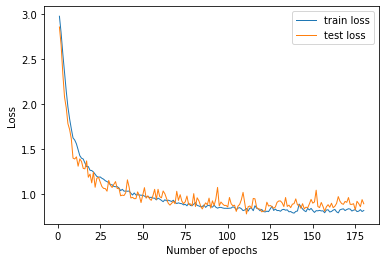

Epoch 181: train_loss=0.8250, train_accuracy=0.7763, test_loss=0.7979, test_accuracy=0.7804.
Epoch 182: train_loss=0.8006, train_accuracy=0.7855, test_loss=0.9403, test_accuracy=0.7578.
Epoch 183: train_loss=0.8122, train_accuracy=0.7793, test_loss=0.8495, test_accuracy=0.7782.
Epoch 184: train_loss=0.8345, train_accuracy=0.7772, test_loss=0.8486, test_accuracy=0.7724.
Epoch 185: train_loss=0.8263, train_accuracy=0.7789, test_loss=0.9186, test_accuracy=0.7680.
Epoch 186: train_loss=0.8081, train_accuracy=0.7818, test_loss=0.9916, test_accuracy=0.7440.
Epoch 187: train_loss=0.8229, train_accuracy=0.7811, test_loss=0.7879, test_accuracy=0.7807.
Epoch 188: train_loss=0.8115, train_accuracy=0.7811, test_loss=0.8863, test_accuracy=0.7753.
Epoch 189: train_loss=0.8005, train_accuracy=0.7831, test_loss=0.9424, test_accuracy=0.7491.
Epoch 190: train_loss=0.7939, train_accuracy=0.7861, test_loss=0.9170, test_accuracy=0.7713.
Performance:


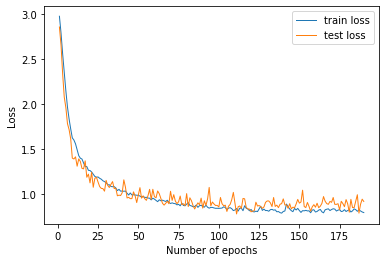

Epoch 191: train_loss=0.8115, train_accuracy=0.7814, test_loss=0.8354, test_accuracy=0.7775.
Epoch 192: train_loss=0.7950, train_accuracy=0.7849, test_loss=0.9376, test_accuracy=0.7575.
Epoch 193: train_loss=0.8090, train_accuracy=0.7817, test_loss=0.8332, test_accuracy=0.7778.
Epoch 194: train_loss=0.8103, train_accuracy=0.7817, test_loss=0.8773, test_accuracy=0.7720.
Epoch 195: train_loss=0.8260, train_accuracy=0.7806, test_loss=0.9040, test_accuracy=0.7669.
Epoch 196: train_loss=0.8029, train_accuracy=0.7820, test_loss=0.8866, test_accuracy=0.7676.
Epoch 197: train_loss=0.8313, train_accuracy=0.7784, test_loss=0.8454, test_accuracy=0.7662.
Epoch 198: train_loss=0.8355, train_accuracy=0.7785, test_loss=0.9027, test_accuracy=0.7611.
Epoch 199: train_loss=0.8110, train_accuracy=0.7842, test_loss=0.8998, test_accuracy=0.7622.
Epoch 200: train_loss=0.8022, train_accuracy=0.7838, test_loss=0.8523, test_accuracy=0.7836.
Performance:


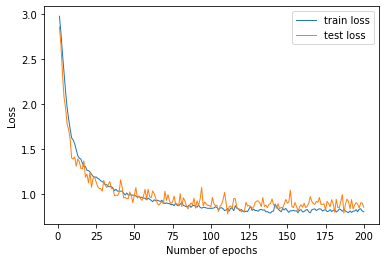

Epoch 201: train_loss=0.8070, train_accuracy=0.7838, test_loss=0.8668, test_accuracy=0.7749.
Epoch 202: train_loss=0.8118, train_accuracy=0.7842, test_loss=0.8927, test_accuracy=0.7720.
Epoch 203: train_loss=0.8097, train_accuracy=0.7817, test_loss=0.9611, test_accuracy=0.7524.
Epoch 204: train_loss=0.8186, train_accuracy=0.7780, test_loss=0.8153, test_accuracy=0.7796.
Epoch 205: train_loss=0.8442, train_accuracy=0.7762, test_loss=0.9052, test_accuracy=0.7727.
Epoch 206: train_loss=0.8305, train_accuracy=0.7773, test_loss=0.9011, test_accuracy=0.7731.
Epoch 207: train_loss=0.8347, train_accuracy=0.7764, test_loss=0.8178, test_accuracy=0.7862.
Epoch 208: train_loss=0.8723, train_accuracy=0.7676, test_loss=0.9827, test_accuracy=0.7571.
Epoch 209: train_loss=0.8164, train_accuracy=0.7859, test_loss=0.8890, test_accuracy=0.7698.
Epoch 210: train_loss=0.8128, train_accuracy=0.7776, test_loss=0.9299, test_accuracy=0.7687.
Performance:


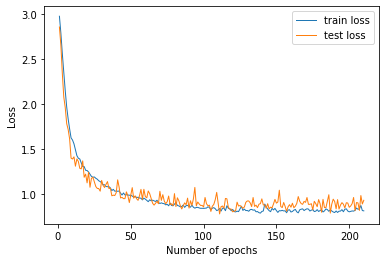

Epoch 211: train_loss=0.8353, train_accuracy=0.7778, test_loss=0.8501, test_accuracy=0.7815.
Epoch 212: train_loss=0.8237, train_accuracy=0.7815, test_loss=0.8778, test_accuracy=0.7684.
Epoch 213: train_loss=0.8346, train_accuracy=0.7776, test_loss=0.8148, test_accuracy=0.7789.
Epoch 214: train_loss=0.7933, train_accuracy=0.7876, test_loss=0.8994, test_accuracy=0.7727.
Epoch 215: train_loss=0.8210, train_accuracy=0.7835, test_loss=0.9331, test_accuracy=0.7691.
Epoch 216: train_loss=0.8333, train_accuracy=0.7760, test_loss=0.8660, test_accuracy=0.7796.
Epoch 217: train_loss=0.8179, train_accuracy=0.7814, test_loss=0.8979, test_accuracy=0.7738.
Epoch 218: train_loss=0.7944, train_accuracy=0.7870, test_loss=0.9558, test_accuracy=0.7560.
Epoch 219: train_loss=0.8226, train_accuracy=0.7819, test_loss=0.8329, test_accuracy=0.7811.
Epoch 220: train_loss=0.8068, train_accuracy=0.7845, test_loss=0.9158, test_accuracy=0.7611.
Performance:


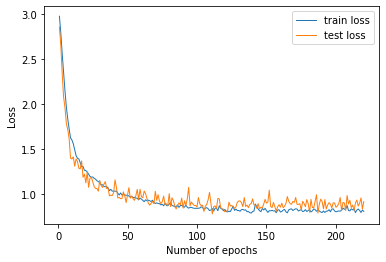

Epoch 221: train_loss=0.8182, train_accuracy=0.7832, test_loss=0.9681, test_accuracy=0.7702.
Epoch 222: train_loss=0.8338, train_accuracy=0.7799, test_loss=0.8697, test_accuracy=0.7760.
Epoch 223: train_loss=0.8231, train_accuracy=0.7800, test_loss=0.9073, test_accuracy=0.7684.
Epoch 224: train_loss=0.8490, train_accuracy=0.7767, test_loss=0.8123, test_accuracy=0.7735.
Epoch 225: train_loss=0.8464, train_accuracy=0.7736, test_loss=0.8832, test_accuracy=0.7840.
Epoch 226: train_loss=0.8592, train_accuracy=0.7755, test_loss=0.9547, test_accuracy=0.7578.
Epoch 227: train_loss=0.8257, train_accuracy=0.7807, test_loss=0.9275, test_accuracy=0.7633.
Epoch 228: train_loss=0.8314, train_accuracy=0.7802, test_loss=0.9951, test_accuracy=0.7665.
Epoch 229: train_loss=0.8392, train_accuracy=0.7768, test_loss=0.8289, test_accuracy=0.7767.
Epoch 230: train_loss=0.8055, train_accuracy=0.7868, test_loss=0.8156, test_accuracy=0.7811.
Performance:


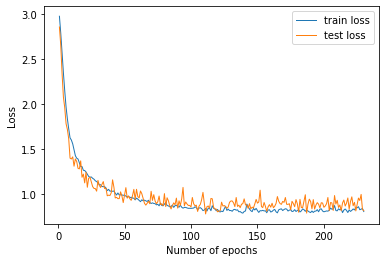

Epoch 231: train_loss=0.8026, train_accuracy=0.7851, test_loss=0.8099, test_accuracy=0.7789.
Epoch 232: train_loss=0.8090, train_accuracy=0.7870, test_loss=0.8327, test_accuracy=0.7818.
Epoch 233: train_loss=0.8241, train_accuracy=0.7863, test_loss=0.8603, test_accuracy=0.7647.
Epoch 234: train_loss=0.7772, train_accuracy=0.7917, test_loss=0.8362, test_accuracy=0.7742.
Epoch 235: train_loss=0.7915, train_accuracy=0.7896, test_loss=0.9073, test_accuracy=0.7618.
Epoch 236: train_loss=0.8340, train_accuracy=0.7793, test_loss=0.8585, test_accuracy=0.7811.
Epoch 237: train_loss=0.8331, train_accuracy=0.7803, test_loss=0.9455, test_accuracy=0.7669.
Epoch 238: train_loss=0.8465, train_accuracy=0.7762, test_loss=0.8471, test_accuracy=0.7764.
Epoch 239: train_loss=0.8526, train_accuracy=0.7763, test_loss=1.0372, test_accuracy=0.7589.
Epoch 240: train_loss=0.8538, train_accuracy=0.7768, test_loss=0.9184, test_accuracy=0.7749.
Performance:


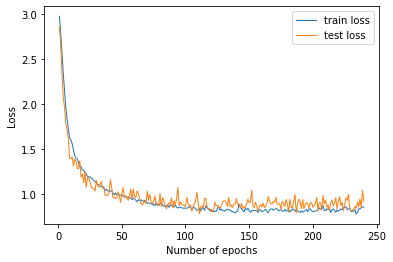

Epoch 241: train_loss=0.8540, train_accuracy=0.7744, test_loss=1.0144, test_accuracy=0.7611.
Epoch 242: train_loss=0.8236, train_accuracy=0.7807, test_loss=0.8922, test_accuracy=0.7695.
Epoch 243: train_loss=0.8461, train_accuracy=0.7799, test_loss=0.9375, test_accuracy=0.7673.
Epoch 244: train_loss=0.8299, train_accuracy=0.7835, test_loss=0.8132, test_accuracy=0.7902.
Epoch 245: train_loss=0.8599, train_accuracy=0.7754, test_loss=0.9837, test_accuracy=0.7625.
Epoch 246: train_loss=0.8415, train_accuracy=0.7800, test_loss=0.9704, test_accuracy=0.7651.
Epoch 247: train_loss=0.8388, train_accuracy=0.7790, test_loss=1.1896, test_accuracy=0.7411.
Epoch 248: train_loss=0.8703, train_accuracy=0.7714, test_loss=0.9044, test_accuracy=0.7625.
Epoch 249: train_loss=0.8381, train_accuracy=0.7773, test_loss=0.9269, test_accuracy=0.7640.
Epoch 250: train_loss=0.8273, train_accuracy=0.7814, test_loss=0.9056, test_accuracy=0.7647.
Performance:


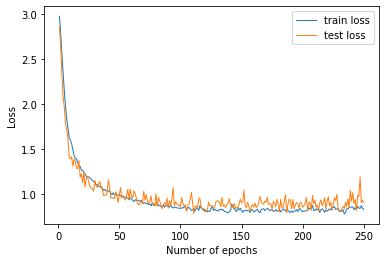

In [7]:
train(num_epochs=250,
      batch_size=256, 
      classifier=build_classifier(learning_rate=1e-3), 
      dataset=dataset, 
      plot_losses_at_epoch=10)